In [ ]:
from google.colab import drive
drive.mount('/content/my_dataset')

Mounted at /content/my_dataset


In [ ]:
# @title imports
# [Info] https://www.tensorflow.org/datasets/catalog/plant_village?hl=es
# Dataset URL: https://data.mendeley.com/datasets/tywbtsjrjv/1
import os
import pandas as pd
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import activations
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import DenseNet121 #, EfficientNetB4, Xception, VGG16, VGG19
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# NO USAR
# def imprime(x,y):
#   %matplotlib inline
#   plt.rcParams['figure.figsize'] = (12, 6) # tamaño de las imágenes
#   # Las mostramos
#   f, ax = plt.subplots(1, 2)
#   ax[0].imshow(x)
#   ax[0].grid(False)
#   ax[0].axis('off')
#   ax[1].imshow(y)
#   ax[1].grid(False)
#   ax[1].axis('off')


In [ ]:
# @title Calculamos los Grad_CAMs
# Hacemos los imports necesarios para calcular los Grand-Cams
import tensorflow as tf
from tensorflow.python.ops.gradients_impl import image_grad
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead


def Grad_CAMs (img, model, layer, INTENSITY,_size_):
  # Procesamos la imagen
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  # model.predict(x)
  # Calculamos los gradientes de la capa de la cual queremos sacar la activación
  with tf.GradientTape() as tape:
    #Extraemos la capa para la cual estamos interesados en obtener el mapa de activación
    last_conv_layer = model.get_layer(layer)
    # Construimos los modelos que vamos a utilizar (desde inputs hasta outputs y desde inputs hasta la última capa convolucional)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    # Obtenemos la clase predicha apra la muestra dada
    class_predict= np.argmax(model_out[0])
    class_out = model_out[:,class_predict]
    #Calculamos los gradientes
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
  # Construimos el mapa de calor
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  # heatmap = heatmap.reshape((56, 56))
  heatmap = heatmap.reshape((_size_,_size_))
  # Hacemos un resize del mapa de calor al tamaño de la imagen y lo multiplicamos por la imagen
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  image_grad = heatmap * INTENSITY + img
  return heatmap, image_grad, class_predict

In [ ]:
# Cargamos las imagenes
# img1 = tf.keras.utils.load_img('ouzel2.jpg', target_size=(224, 224))
img1 = tf.keras.utils.load_img('/content/my_dataset/MyDrive/TFM/image (6).JPG' ,target_size=(224, 224))
# img2 = tf.keras.utils.load_img('/content/image (3).JPG',target_size=(224, 224))
# img6 = tf.keras.utils.load_img('/content/image (6).JPG',target_size=(224, 224))

In [ ]:
# @title Build model mobileNet
batch_size = 64
img_width, img_height = 224, 224
mobile = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                                  include_top=True,
                                                  weights='imagenet')

mobile.trainable = False  # Freeze the base model

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobile.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# for layer in mobile.layers:
#     print(layer)
mobile.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,538,984 (13.50 MB)

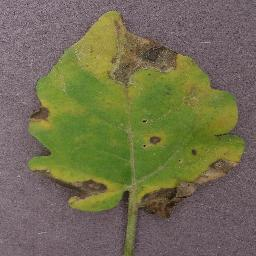

In [ ]:
img1

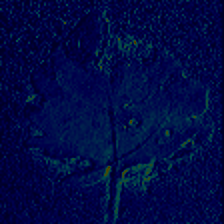

In [ ]:
heatmap_1, imagen_1, class_out_1 = Grad_CAMs(img_to_array(img1), mobile,'Conv1', 0.3,112)

cv2_imshow(imagen_1)


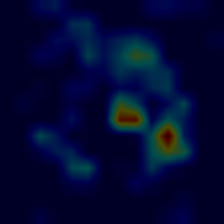

In [ ]:
heatmap_1, imagen_1, class_out_1 = Grad_CAMs(img_to_array(img1), mobile,'block_8_add', 0.3,int(28/2))

cv2_imshow(imagen_1)

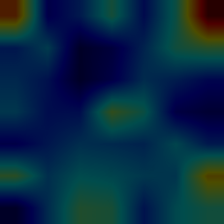

In [ ]:
heatmap_1, imagen_1, class_out_1 = Grad_CAMs(img_to_array(img1), mobile,'block_16_expand_BN', 0.3,7)

cv2_imshow(imagen_1)

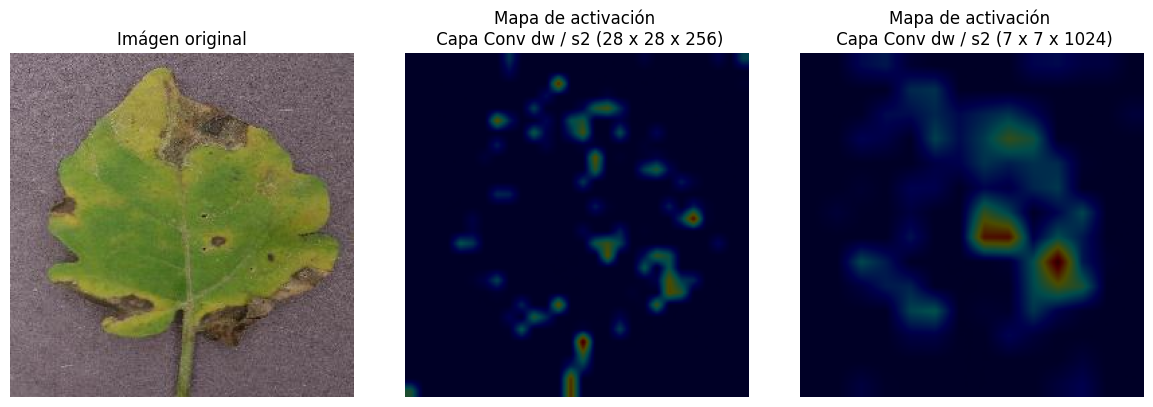

In [ ]:
# @title cargamos los ejemplos anteriores

import matplotlib.pyplot as plt
from PIL import Image

image1 = Image.open('/content/act_ma_1.png')
image2 = Image.open('/content/act_map_2.png')
image3 = Image.open('/content/act_map_original.png')


fig, axes = plt.subplots(1, 3, figsize=(12, 4))


axes[0].imshow(image3)
axes[0].set_title('Imágen original')
axes[0].axis('off')

axes[1].imshow(image1)
axes[1].set_title('Mapa de activación \n Capa Conv dw / s2 (28 x 28 x 256)')
axes[1].axis('off')

axes[2].imshow(image2)
axes[2].set_title('Mapa de activación \n Capa Conv dw / s2 (7 x 7 x 1024)')
axes[2].axis('off')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()
